<a href="https://colab.research.google.com/github/arnabbiswas66/multimodal-fake-news-classifier/blob/main/Analysis/Weibo_multimodal_classifier_Scaled_Attention_Analysis_tsne.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -q tensorflow_text

In [3]:
from tensorflow.python.platform.tf_logging import warn
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
import re
from os import listdir
import shutil
import glob
import copy
import random
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import tensorflow_text as text
tf.get_logger().setLevel('ERROR')
import warnings

warnings.filterwarnings('ignore')

import random
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

## Initial Google Drive and Colab setup

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
BASE_SAVE_LOCATION = "/content/drive/MyDrive/multimodal-news"
CHECKPOINT_FILEPATH = '/content/drive/MyDrive/multimodal-news/weibo/'

In [6]:
# image copy pipeline from Gdrive to Colab
! mkdir "/content/images"
! cp "/content/drive/MyDrive/multimodal-news/weibo-data/images.zip" "/content/images"
! unzip -q -d "/content/images" "/content/images/images.zip"

## Load the dataframes

In [7]:
#Load training df
train_df_model = pd.read_pickle(BASE_SAVE_LOCATION+"/weibo-train.pickle")
#Load testing df
test_df_model = pd.read_pickle(BASE_SAVE_LOCATION+"/weibo-test.pickle")
print(train_df_model.shape, test_df_model.shape)

(4140, 3) (1124, 3)


# Data input pipeline

In [8]:
# Define TF Hub paths to the BERT encoder and its preprocessor
bert_model_path = (
    "https://tfhub.dev/tensorflow/bert_zh_L-12_H-768_A-12/4"
)
bert_preprocess_path = "https://tfhub.dev/tensorflow/bert_zh_preprocess/3"

In [9]:
def make_bert_preprocessing_model(sentence_features, seq_length=128):
    """Returns Model mapping string features to BERT inputs.

  Args:
    sentence_features: A list with the names of string-valued features.
    seq_length: An integer that defines the sequence length of BERT inputs.

  Returns:
    A Keras Model that can be called on a list or dict of string Tensors
    (with the order or names, resp., given by sentence_features) and
    returns a dict of tensors for input to BERT.
  """

    input_segments = [
        tf.keras.layers.Input(shape=(), dtype=tf.string, name=ft)
        for ft in sentence_features
    ]

    # Tokenize the text to word pieces.
    bert_preprocess = hub.load(bert_preprocess_path)
    tokenizer = hub.KerasLayer(bert_preprocess.tokenize, name="tokenizer")
    segments = [tokenizer(s) for s in input_segments]

    # Optional: Trim segments in a smart way to fit seq_length.
    # Simple cases (like this example) can skip this step and let
    # the next step apply a default truncation to approximately equal lengths.
    truncated_segments = segments

    # Pack inputs. The details (start/end token ids, dict of output tensors)
    # are model-dependent, so this gets loaded from the SavedModel.
    packer = hub.KerasLayer(
        bert_preprocess.bert_pack_inputs,
        arguments=dict(seq_length=seq_length),
        name="packer",
    )
    model_inputs = packer(truncated_segments)
    return keras.Model(input_segments, model_inputs)


In [10]:
bert_preprocess_model = make_bert_preprocessing_model(["text_1"], 224)
bert_preprocess_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_1 (InputLayer)         [(None,)]                 0         
                                                                 
 tokenizer (KerasLayer)      (None, None, None)        0         
                                                                 
 packer (KerasLayer)         {'input_word_ids': (None  0         
                             , 224),                             
                              'input_mask': (None, 22            
                             4),                                 
                              'input_type_ids': (None            
                             , 224)}                             
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [11]:
idx = np.random.choice(len(train_df_model))
row = train_df_model.iloc[idx]
sample_text_1, sample_text_2 = row["tweetText"], row["tweetText"]
print(f"Text 1: {sample_text_1}")
print(f"Text 2: {sample_text_2}")

test_text = [np.array([sample_text_1])]
text_preprocessed = bert_preprocess_model(test_text)

print("Keys           : ", list(text_preprocessed.keys()))
print("Shape Word Ids : ", text_preprocessed["input_word_ids"].shape)
print("Word Ids       : ", text_preprocessed["input_word_ids"][0, :16])
print("Shape Mask     : ", text_preprocessed["input_mask"].shape)
print("Input Mask     : ", text_preprocessed["input_mask"][0, :16])
print("Shape Type Ids : ", text_preprocessed["input_type_ids"].shape)
print("Type Ids       : ", text_preprocessed["input_type_ids"][0, :16])


Text 1: 云南母猪生小孩照片（奇闻） 近来，有网友发贴称:云南省昆明市宜良县的一个小山村发生一件怪事，一只母猪居然生下8个男婴儿，在场所有人都不敢相信自己的眼睛。各国专家赶到现场都无法解释这一奇特迹象，这将成为世界历史上的未解之谜！
Text 2: 云南母猪生小孩照片（奇闻） 近来，有网友发贴称:云南省昆明市宜良县的一个小山村发生一件怪事，一只母猪居然生下8个男婴儿，在场所有人都不敢相信自己的眼睛。各国专家赶到现场都无法解释这一奇特迹象，这将成为世界历史上的未解之谜！
Keys           :  ['input_word_ids', 'input_mask', 'input_type_ids']
Shape Word Ids :  (1, 224)
Word Ids       :  tf.Tensor(
[ 101  756 1298 3678 4343 4495 2207 2111 4212 4275 8020 1936 7319 8021
 6818 3341], shape=(16,), dtype=int32)
Shape Mask     :  (1, 224)
Input Mask     :  tf.Tensor([1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1], shape=(16,), dtype=int32)
Shape Type Ids :  (1, 224)
Type Ids       :  tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(16,), dtype=int32)


In [12]:
def dataframe_to_dataset(dataframe):
    columns = ['tweetText', 'image_1', 'label']
    dataframe = dataframe[columns].copy()
    labels = dataframe.pop("label")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds

## Preprocessing utilities

In [13]:
resize = (224, 224)
bert_input_features = ["input_word_ids", "input_type_ids", "input_mask"]

In [14]:
def preprocess_image(image_path):
  extension = tf.strings.split(image_path,'.')[-1]
  image = tf.io.read_file(image_path)
  if extension == b"gif":
    image = tf.io.decode_image(image, 3, expand_animations=False)
  elif extension == b"png":
    image = tf.image.decode_png(image, 3)
  else:
    image = tf.image.decode_jpeg(image, 3)
  image = tf.image.resize(image, resize)
  return image

In [15]:
def preprocess_text(text_1):
  text_1 = tf.convert_to_tensor([text_1])
  output = bert_preprocess_model([text_1])
  output = {feature: tf.squeeze(output[feature]) for feature in bert_input_features}
  return output

In [16]:
def preprocess_text_and_image(sample):
  image_1 = preprocess_image(sample["image_1"])
  text = preprocess_text(sample["tweetText"])
  return {"image_1": image_1, "text": text}

In [17]:
batch_size = 32
auto = tf.data.AUTOTUNE

In [18]:
def prepare_dataset(dataframe, training=True):
  ds = dataframe_to_dataset(dataframe)
  if training:
      ds = ds.shuffle(len(train_df_model))
  ds = ds.map(lambda x, y: (preprocess_text_and_image(x), y)).cache()
  ds = ds.batch(batch_size).prefetch(auto)
  return ds

In [19]:
train_ds = prepare_dataset(train_df_model)
test_ds = prepare_dataset(test_df_model, False)

## Model Building

### Projection

In [20]:
def project_embeddings(
    embeddings, num_projection_layers, projection_dims, dropout_rate
):
    projected_embeddings = keras.layers.Dense(units=projection_dims)(embeddings)
    for _ in range(num_projection_layers):
        x = tf.nn.gelu(projected_embeddings)
        x = keras.layers.Dense(projection_dims)(x)
        x = keras.layers.Dropout(dropout_rate)(x)
        x = keras.layers.Add()([projected_embeddings, x])
        projected_embeddings = keras.layers.LayerNormalization()(x)
    return projected_embeddings


### Vision encoder

In [21]:
def create_vision_encoder(
    num_projection_layers, projection_dims, dropout_rate, trainable=False
):
    # Load the pre-trained ResNet50V2 model to be used as the base encoder.
    resnet_v2 = keras.applications.EfficientNetV2B3(
        include_top=False, weights="imagenet", pooling="avg"
    )
    # Set the trainability of the base encoder.
    for layer in resnet_v2.layers:
        layer.trainable = trainable

    # Receive the images as inputs.
    image_1 = keras.Input(shape=(224, 224, 3), name="image_1")
    
    # Preprocess the input image.
    preprocessed_1 = keras.applications.resnet_v2.preprocess_input(image_1)
    
    # Generate the embeddings for the images using the resnet_v2 model
    # concatenate them.
    embeddings = resnet_v2(preprocessed_1)
    #embeddings = keras.layers.Concatenate()([embeddings_1, embeddings_2])
    #print("Image embeddings shape before", embeddings.shape)
    # Project the embeddings produced by the model.
    outputs = project_embeddings(
        embeddings, num_projection_layers, projection_dims, dropout_rate
    )
    #print("Image embeddings shape After", outputs.shape)
    # Create the vision encoder model.
    return keras.Model([image_1], outputs, name="vision_encoder")

### Text Encoder

In [22]:
def create_text_encoder(
    num_projection_layers, projection_dims, dropout_rate, trainable=False
):
    # Load the pre-trained BERT model to be used as the base encoder.
    bert = hub.KerasLayer(bert_model_path, name="bert",)
    # Set the trainability of the base encoder.
    bert.trainable = trainable

    # Receive the text as inputs.
    bert_input_features = ["input_type_ids", "input_mask", "input_word_ids"]
    inputs = {
        feature: keras.Input(shape=(224,), dtype=tf.int32, name=feature)
        for feature in bert_input_features
    }

    # Generate embeddings for the preprocessed text using the BERT model.
    embeddings = bert(inputs)["pooled_output"]

    # Project the embeddings produced by the model.
    outputs = project_embeddings(
        embeddings, num_projection_layers, projection_dims, dropout_rate
    )
    # Create the text encoder model.
    return keras.Model(inputs, outputs, name="text_encoder")

### Multi Head Attention Layer

In [23]:
class TransformerBlock(keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [keras.layers.Dense(ff_dim, activation="relu"), keras.layers.Dense(embed_dim),]
        )
        self.layernorm1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)

    def call(self, x, y, training):
        attn_output = self.att(x, y)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

## MultiModal model

In [24]:
def create_multimodal_model(
    num_projection_layers=0,
    projection_dims=224,
    dropout_rate=0.1,
    vision_trainable=False,
    text_trainable=False,
    attention=False
):
    # Receive the images as inputs.
    image_1 = keras.Input(shape=(224, 224, 3), name="image_1")
    
    # Receive the text as inputs.
    bert_input_features = ["input_type_ids", "input_mask", "input_word_ids"]
    text_inputs = {
        feature: keras.Input(shape=(224,), dtype=tf.int32, name=feature)
        for feature in bert_input_features
    }

    # Create the encoders.
    vision_encoder = create_vision_encoder(
        num_projection_layers, projection_dims, dropout_rate, vision_trainable
    )
    text_encoder = create_text_encoder(
        num_projection_layers, projection_dims, dropout_rate, text_trainable
    )

    # Fetch the embedding projections.
    vision_projections = vision_encoder([image_1])
    vision_projections = keras.layers.Dropout(dropout_rate)(vision_projections)
    text_projections = text_encoder(text_inputs)
    text_projections = keras.layers.Dropout(dropout_rate)(text_projections)
    
    # Cross-attention.
    if attention:
      transformer_block = TransformerBlock(projection_dims, 4, projection_dims)
      x = transformer_block(tf.expand_dims(vision_projections, -1), tf.expand_dims(text_projections, -1))
      x = tf.keras.layers.Flatten()(x)
      
    # Concatenate the projections and pass through the classification layer.
    concatenated = keras.layers.Concatenate()([vision_projections, text_projections])
    if attention:
        concatenated = keras.layers.Concatenate()([concatenated, x])
        #x = tf.keras.layers.Flatten(x)
    outputs = keras.layers.Dense(1, activation="sigmoid")(concatenated)
    return keras.Model([image_1, text_inputs], outputs)

In [25]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics= [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

In [26]:
multimodal_model = create_multimodal_model(attention=True, num_projection_layers=1, projection_dims=128)

52606240/52606240 [==============================] - 0s 0us/step


### Model Training

In [27]:
epochs = 10
batch_size = 64

In [28]:
multimodal_model.compile(
    optimizer=tf.keras.optimizers.Adam(), loss=loss, metrics=metrics)
history = multimodal_model.fit(train_ds, validation_data=test_ds, epochs=epochs, batch_size=batch_size)

Epoch 1/10
130/130 [==============================] - 135s 786ms/step - loss: 0.4937 - accuracy: 0.8070 - precision: 0.4963 - recall: 0.3384 - val_loss: 0.5228 - val_accuracy: 0.7758 - val_precision: 0.5110 - val_recall: 0.8893
Epoch 2/10
130/130 [==============================] - 100s 769ms/step - loss: 0.2935 - accuracy: 0.8785 - precision: 0.7128 - recall: 0.6151 - val_loss: 0.3054 - val_accuracy: 0.8719 - val_precision: 0.8430 - val_recall: 0.5534
Epoch 3/10
130/130 [==============================] - 100s 767ms/step - loss: 0.2604 - accuracy: 0.8906 - precision: 0.7402 - recall: 0.6629 - val_loss: 0.2813 - val_accuracy: 0.8781 - val_precision: 0.7854 - val_recall: 0.6565
Epoch 4/10
130/130 [==============================] - 100s 768ms/step - loss: 0.2331 - accuracy: 0.9027 - precision: 0.7685 - recall: 0.7057 - val_loss: 0.2830 - val_accuracy: 0.8799 - val_precision: 0.7510 - val_recall: 0.7252
Epoch 5/10
130/130 [==============================] - 100s 767ms/step - loss: 0.2123 - a

In [29]:
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score

In [30]:
y_test = np.concatenate([y for x, y in test_ds], axis=0)

In [31]:
y_pred = multimodal_model.predict(test_ds)
y_pred = [1 if i>=0.5 else 0 for i in y_pred]
print(f'Accuracy == {accuracy_score(y_test,y_pred)}')
print(f'F1 == {f1_score(y_test,y_pred,average=None)}')
print(f'Precision == {precision_score(y_test,y_pred,average=None)}')
print(f'Recall == {recall_score(y_test,y_pred,average=None)}')

36/36 [==============================] - 24s 580ms/step
Accuracy == 0.8896797153024911
F1 == [0.92873563 0.75590551]
Precision == [0.92027335 0.7804878 ]
Recall == [0.93735499 0.73282443]


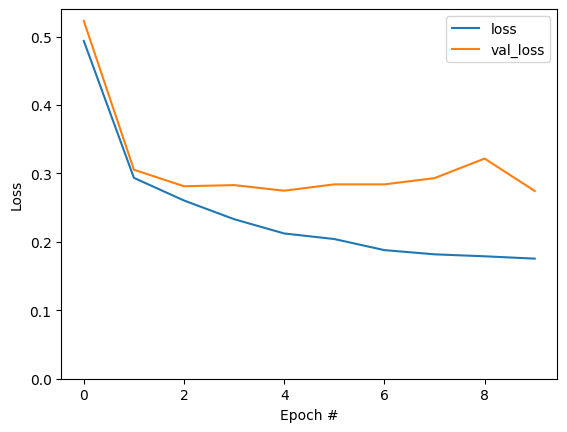

In [32]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

Plot training accuracy vs tersting accuracy

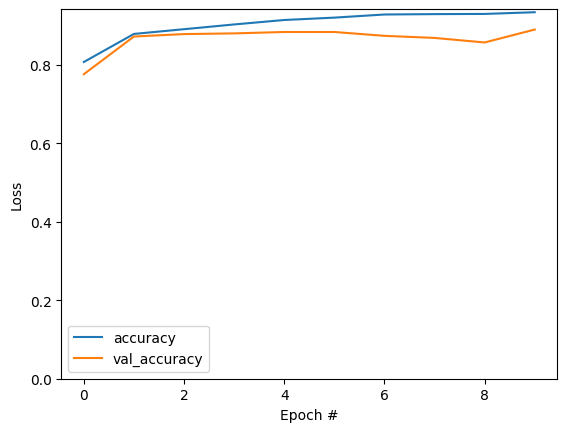

In [33]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

In [34]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc_score = auc(fpr, tpr)

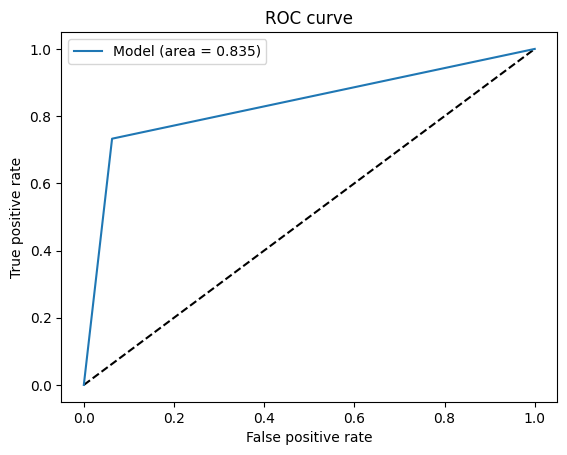

In [35]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Model (area = {:.3f})'.format(auc_score))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [36]:
multimodal_model2 = create_multimodal_model(attention=True, num_projection_layers=1, projection_dims=128, dropout_rate=0.2)

In [37]:
multimodal_model2.compile(
    optimizer=tf.keras.optimizers.Adam(), loss=loss, metrics=metrics)
history = multimodal_model2.fit(train_ds, validation_data=test_ds, epochs=epochs, batch_size=32)

Epoch 1/10
130/130 [==============================] - 126s 800ms/step - loss: 0.5284 - accuracy: 0.8209 - precision: 0.5718 - recall: 0.4295 - val_loss: 0.4275 - val_accuracy: 0.8096 - val_precision: 0.5597 - val_recall: 0.8588
Epoch 2/10
130/130 [==============================] - 100s 770ms/step - loss: 0.3020 - accuracy: 0.8766 - precision: 0.7082 - recall: 0.6075 - val_loss: 0.3512 - val_accuracy: 0.8692 - val_precision: 0.8808 - val_recall: 0.5076
Epoch 3/10
130/130 [==============================] - 100s 769ms/step - loss: 0.2626 - accuracy: 0.8896 - precision: 0.7394 - recall: 0.6566 - val_loss: 0.3008 - val_accuracy: 0.8728 - val_precision: 0.8324 - val_recall: 0.5687
Epoch 4/10
130/130 [==============================] - 100s 769ms/step - loss: 0.2419 - accuracy: 0.8998 - precision: 0.7624 - recall: 0.6943 - val_loss: 0.3072 - val_accuracy: 0.8692 - val_precision: 0.6849 - val_recall: 0.8130
Epoch 5/10
130/130 [==============================] - 100s 769ms/step - loss: 0.2149 - a

In [38]:
y_pred = multimodal_model2.predict(test_ds)
y_pred = [1 if i>=0.5 else 0 for i in y_pred]
print(f'Accuracy == {accuracy_score(y_test,y_pred)}')
print(f'F1 == {f1_score(y_test,y_pred,average=None)}')
print(f'Precision == {precision_score(y_test,y_pred,average=None)}')
print(f'Recall == {recall_score(y_test,y_pred,average=None)}')

36/36 [==============================] - 24s 584ms/step
Accuracy == 0.8816725978647687
F1 == [0.92208553 0.75415896]
Precision == [0.93136095 0.7311828 ]
Recall == [0.91299304 0.77862595]


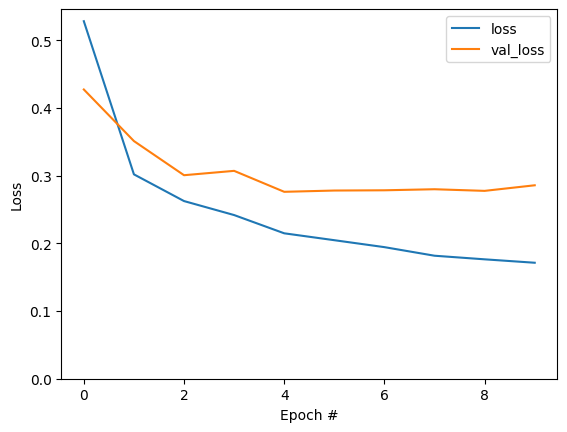

In [39]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

Plot training accuracy vs tersting accuracy

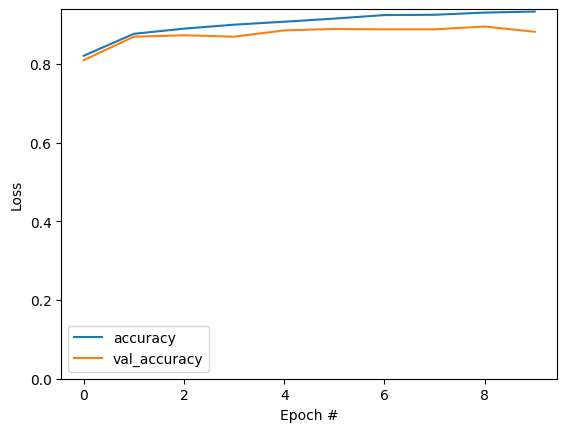

In [40]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

In [41]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc_score = auc(fpr, tpr)

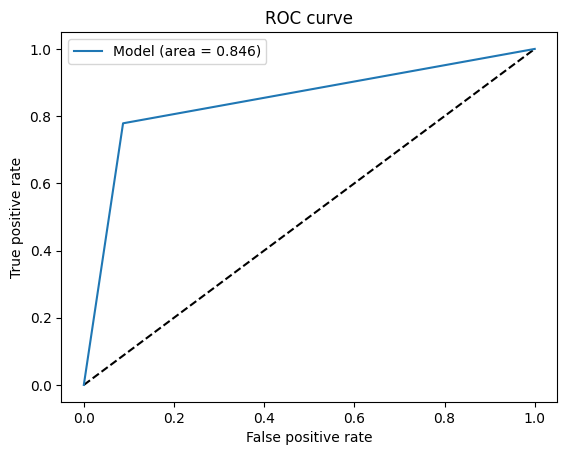

In [42]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Model (area = {:.3f})'.format(auc_score))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# t-SNE visulaization

In [43]:
model2 = tf.keras.Model(inputs=multimodal_model2.input, outputs=multimodal_model2.layers[-2].output)
features = model2.predict(test_ds)

36/36 [==============================] - 27s 592ms/step


In [44]:
from sklearn.manifold import TSNE

In [45]:
labels = y_pred
tsne = TSNE(n_components=2, random_state=42).fit_transform(features)

In [46]:
def scale_to_01_range(x):
  value_range = (np.max(x) - np.min(x))
  starts_from_zero = x - np.min(x)
  return starts_from_zero / value_range

In [47]:
tx = tsne[:, 0]
ty = tsne[:, 1]
tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)

In [48]:
colors = ['red', 'blue']
classes = ['fake', 'real']
print(classes)

['fake', 'real']


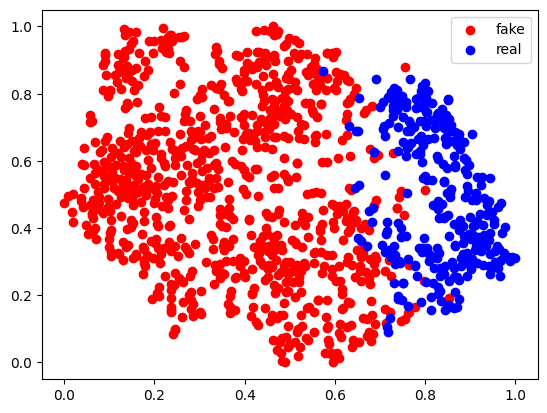

In [49]:
fig = plt.figure()
ax = fig.add_subplot(111)
for idx, c in enumerate(colors):
    indices = [i for i, l in enumerate(labels) if idx == l]
    current_tx = np.take(tx, indices)
    current_ty = np.take(ty, indices)
    ax.scatter(current_tx, current_ty, c=c, label=classes[idx])

ax.legend(loc='best')
plt.show()